# Title: Twitter US Airlines Sentiment Analysis - Part 2

### Project Overview

This project aims to analyze the sentiment of tweets directed at various U.S. airlines. The dataset used in this analysis is the "Twitter US Airline Sentiment" dataset, which contains tweets classified as positive, neutral, or negative. The goal of this project is to build a machine learning model that can accurately predict the sentiment of tweets based on their text content.

**This is Part 2 of the project, where I will use the pre-trained BERT model.**

### Dataset Description
The "Twitter US Airline Sentiment" dataset is publicly available on Kaggle and contains over 14,000 tweets about major U.S. airlines, labeled with sentiment categories. The dataset provides valuable insights into customer satisfaction and sentiment toward different airlines.

[Dataset URL](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

**Dataset Features**

| Feature                       | Description                                                                           |
|-------------------------------|---------------------------------------------------------------------------------------|
| `tweet_id`                    | Unique identifier for each tweet.                                                     |
| `airline_sentiment`           | The sentiment label for the tweet, which can be one of the following categories:      |
|                               | - positive                                                                           |
|                               | - neutral                                                                            |
|                               | - negative                                                                           |
| `airline_sentiment_confidence`| Confidence level in the sentiment classification.                                     |
| `negativereason`              | The reason for negative sentiment, if applicable (e.g., "Late Flight," "Cancelled Flight"). |
| `negativereason_confidence`   | Confidence level in the negative reason classification.                               |
| `airline`                     | The airline to which the tweet is directed (e.g., "United," "American").              |
| `airline_sentiment_gold`      | A gold standard label for the tweet's sentiment, if available.                        |
| `name`                        | The name of the user who posted the tweet.                                            |
| `negativereason_gold`         | A gold standard label for the negative reason, if available.                          |
| `retweet_count`               | The number of retweets for the tweet.                                                 |
| `text`                        | The actual tweet content.                                                             |
| `tweet_coord`                 | Coordinates of the tweet, if available.                                               |
| `tweet_created`               | The timestamp when the tweet was created.                                             |
| `tweet_location`              | The location of the tweet, if available.                                              |
| `user_timezone`               | The timezone of the user who posted the tweet.                                        |



In [2]:
# Load Libraties

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os

# import evaluate
import tensorflow
from tensorflow import keras
from datasets import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, pipeline, create_optimizer, KerasMetricCallback

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split

## Load Dataset

In [ ]:
# Load dataset
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Analysis

In [ ]:
# For this task the features that will be used are airline_sentiment and text
df = df[['airline_sentiment', 'text']]

df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [ ]:
# Shape
print('Dataset shape:', df.shape)

Dataset shape: (14640, 2)


In [ ]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [ ]:
# Missing values
print(f'This dataset has {df.isna().sum().sum()} missing values.')

This dataset has 0 missing values.


In [ ]:
# Duplicates
print(f'This dataset has {df.duplicated().sum()} duplicate values.\n')

df[df.duplicated()]

This dataset has 188 duplicate values.



,airline_sentiment,text
331,positive,@VirginAmerica Thanks!
515,positive,@united thanks
1477,positive,@united thank you!
1864,positive,@united thank you
1938,positive,@united thank you
...,...,...
13995,negative,@AmericanAir 800 number will not even let you...
14386,negative,@AmericanAir I want to speak to a human being!...
14392,negative,@AmericanAir no response to DM or email yet. ...
14543,negative,@AmericanAir should reconsider #usairways acqu...


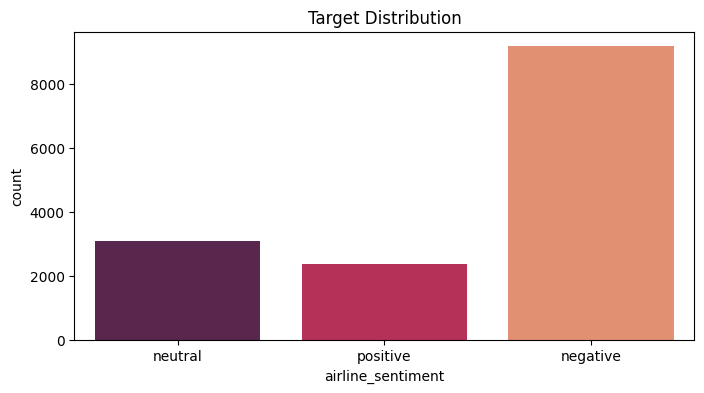

In [ ]:
# Target distribution
plt.figure(figsize = (8,4))
sns.countplot(data = df, x = 'airline_sentiment',hue ='airline_sentiment', palette='rocket')
plt.title('Target Distribution')
plt.show()

**Based on the analysis, this dataset contains no missing values.
There are 188 duplicate entries, which will be removed. The target variable is imbalanced, with the majority of sentiments being negative.**

## Preprocessing

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

df[df.duplicated()]

,airline_sentiment,text


In [ ]:
# Encode target feature
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(target_map)

## Split on train-test

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Convert to tensorflow dataset
train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'labels': test_labels})

In [ ]:
train_dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 11561
})

## Tokenization using BERT Tokenizer

In [3]:
# Define bert
checkpoint = 'distilbert-base-uncased'

# load using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Define tokenization function
def tokenize_function(examples):
  return tokenizer(examples['text'], truncation = True)

In [ ]:
# Apply the tokenization function to the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/11561 [00:00<?, ? examples/s]

Map:   0%|          | 0/2891 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 11561
})

In [ ]:
# Define Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True,  return_tensors="tf")

In [ ]:
# Convert to tensorflow datasets
tf_train_dataset = train_dataset.to_tf_dataset( columns = ['input_ids', 'attention_mask'],
                                               label_cols= 'labels',
                                                shuffle = True, batch_size = 8
                                                ,collate_fn=data_collator)

tf_test_dataset = test_dataset.to_tf_dataset( columns = ['input_ids', 'attention_mask'],
                                               label_cols= 'labels',
                                                shuffle = False, batch_size = 8
                                                ,collate_fn=data_collator)

In [ ]:
for batch in tf_train_dataset.take(3):
    inputs, labels = batch
    input_ids = inputs['input_ids'].numpy()

    sequence_lengths = [len(seq) for seq in input_ids]
    print("Sequence lengths in the batch:", sequence_lengths)
    print("All sequences have the same length:", all(length == sequence_lengths[0] for length in sequence_lengths))

Sequence lengths in the batch: [40, 40, 40, 40, 40, 40, 40, 40]
All sequences have the same length: True
Sequence lengths in the batch: [36, 36, 36, 36, 36, 36, 36, 36]
All sequences have the same length: True
Sequence lengths in the batch: [38, 38, 38, 38, 38, 38, 38, 38]
All sequences have the same length: True


## Load Pre-Trained Model

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## Train Model

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-5, weight_decay=0.01),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [ ]:
# callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
tensorflow.config.run_functions_eagerly(True)

**Since a GPU was not available, I trained the model for only 2 epochs (1:30 hours per epoch) using a CPU**

In [ ]:
# Train
num_epochs = 2

history = model.fit(tf_train_dataset,
                  validation_data=tf_test_dataset,
                  epochs=num_epochs)

Epoch 1/2
1446/1446 [==============================] - 4896s 3s/step - loss: 0.4961 - accuracy: 0.8028 - val_loss: 0.4249 - val_accuracy: 0.8326
Epoch 2/2
1446/1446 [==============================] - 5143s 4s/step - loss: 0.3186 - accuracy: 0.8821 - val_loss: 0.4412 - val_accuracy: 0.8378


## Save model

In [ ]:
save_path = 'my_model'
os.mkdir(save_path)

In [ ]:
# Save model
model.save_pretrained(save_path)

## Evaluate model

In [ ]:
accuracy_metric = evaluate.load("accuracy")

In [ ]:
predictions = model.predict(tf_test_dataset)
predictions

362/362 [==============================] - 295s 807ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 3.1115258 , -2.3384478 , -0.7127537 ],
       [ 3.9264264 , -2.6885202 , -1.2574872 ],
       [ 1.9012616 , -1.6499314 , -0.24244587],
       ...,
       [ 1.5063953 , -0.9348521 , -0.47111556],
       [ 3.5993276 , -2.4018893 , -1.2628142 ],
       [-2.6143627 ,  2.0917766 , -0.00912475]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
class_preds = np.argmax(predictions['logits'], axis = 1)
print('Accuracy:', accuracy_metric.compute(predictions = class_preds, references = test_dataset['labels']))

Accuracy: {'accuracy': 0.837772397094431}


## Test Model on new sentences

In [ ]:
new_sentences = [
    "It was an awful trip; the flight was very late, and it was so full and smelly.",
    "This is going to be nice trip, can't wait."]

# Tokenize the sentences
encoded_inputs = tokenizer(new_sentences, padding=True, truncation=True, return_tensors='tf')

# Perform inference
outputs = model(encoded_inputs)
logits = outputs.logits
predictions = np.argmax(logits, axis=1)

# Print results
for sentence, prediction in zip(new_sentences, predictions):
  if prediction == 0:

    print(f"Sentence: {sentence}")
    print(f"Prediction: {prediction}, is negative")

  elif prediction == 1:

    print(f"Sentence: {sentence}")
    print(f"Prediction: {prediction}, is positive")

  else:
    print(f"Sentence: {sentence}")
    print(f"Prediction: {prediction}, is neutral")

Sentence: It was an awfull trip, the flight was very late and it was so full and smelly
Prediction: 0, is negative
Sentence: This is going to be nice trip, can't wait.
Prediction: 1, is positive
